# MLP 

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
from csv import reader
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import math
import random
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-11 13:09:07.729358
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization

dt='float32'
tf.keras.backend.set_floatx(dt)

from KmerCounter import KmerCounter
K=4
counter = KmerCounter()
counter.setK(K)
VOCABULARY_SIZE = counter.get_vocabulary_size()

from TrainValidSplit import Splitter
EPOCHS=10

from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
SEQUENCE_FILE = 'Homo_sapiens.GRCh38.cds.csv'
COUNTS_FILE=f"cds.kmer_counts.k{K}.npy"

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Load labels and sequences

In [5]:
splitter=Splitter()

In [6]:
RCI_THRESHOLDS=(-1,1)
def load_labels(atlas_file,cells):
    gene_labels = {}
    with open(atlas_file,'r') as atlas:
        header = None
        genes_considered = 0
        positives = 0
        csv = reader(atlas)
        for row in csv:
            if header is None:
                header = row
            else:
                gene = row[0]
                genes_considered += 1
                rci = float(row[1+cells])
                if not math.isnan(rci):
                    # GENERATE BINARY LABELS
                    if rci < RCI_THRESHOLDS[0]:
                        label = 0   # RCI<0
                        gene_labels[gene]=label
                    elif rci >= RCI_THRESHOLDS[1]:
                        label = 1   #RCI>=0
                        positives += 1
                        gene_labels[gene]=label
    print('ATLAS Genes:',genes_considered)
    print('Filter for genes with RCI labels from cell line:',cells)
    print('Labeled genes:',len(gene_labels))
    print('Positive labels:',positives)
    return gene_labels
    
print(datetime.now())
atlas_path = ATLAS_DIR+RCI_FILE
gene_to_label = load_labels(atlas_path,CELL_LINE_NUMBER)

2022-10-11 13:09:15.503156
ATLAS Genes: 14216
Filter for genes with RCI labels from cell line: 0
Labeled genes: 4022
Positive labels: 1898


In [7]:
def load_sequences(gencode_file,labeled_genes):
    gid_tid = []
    with open(gencode_file,'r') as gencode:
        header = None
        csv = reader(gencode)
        rownum = 0
        for row in csv:
            if header is None:
                header = row
            else:
                tran_id = row[0]
                gene_id = row[1]
                if gene_id in labeled_genes:
                    label = labeled_genes[gene_id]
                    gid_tid.append((gene_id,tran_id,rownum,label))
            rownum += 1
    return gid_tid

In [8]:
print(datetime.now())
gencode_path = GENCODE_DIR+SEQUENCE_FILE
gid_tid_row_label = load_sequences(gencode_path,gene_to_label)
print(datetime.now())

2022-10-11 13:09:15.596156
2022-10-11 13:09:16.868544


In [9]:
print(datetime.now())
INPUT_BINARY = GENCODE_DIR+COUNTS_FILE
ordered_kmer_counts = np.load(INPUT_BINARY,allow_pickle=True)
print(datetime.now())

2022-10-11 13:09:16.895191
2022-10-11 13:09:17.397739


In [10]:
splitter.set_ids(gid_tid_row_label)
splitter.set_counts(ordered_kmer_counts)
splitter.randomize()

## Build model

In [11]:
def build_model():
    act="sigmoid"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(64, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    #output_layer = keras.layers.Dense(1,  activation="softmax",dtype=dt)
    output_layer = keras.layers.Dense(1,  activation=act,dtype=dt)

    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    mlp.add(dense3_layer)
    mlp.add(output_layer)
    
    # Logit=True ranges from + to - infinity.
    # Logit=False i.e. probabilities range from 0 to 1.
    # If your output layer has a 'softmax' activation, from_logits should be False. If your output layer doesn't have a 'softmax' activation, from_logits should be True. 
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

## Cross validation

In [12]:
def do_cross_validation(splitter,eps):
    cv_scores = []
    fold=0
    PARTITIONS=5
    for i in range(PARTITIONS):
        X_train,y_train,X_valid,y_valid = \
            splitter.train_valid_split(i,PARTITIONS)
        print('Fold',i)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


2022-10-11 13:09:17.488635
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24,833
Trainable params: 24,833
Non-trainable params: 0
_________________________________________________________________
None
Cross valiation


2022-10-11 13:09:17.509488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fold 0
Train set ones/size 7105 / 15894
Valid set ones/size 1774 / 3950
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
497/497 [==============================] - 2s 4ms/step - loss: 0.5335 - accuracy: 0.7466 - val_loss: 0.5434 - val_accuracy: 0.7390
Epoch 2/10
497/497 [==============================] - 1s 3ms/step - loss: 0.4933 - accuracy: 0.7783 - val_loss: 0.5247 - val_accuracy: 0.7544
Epoch 3/10
497/497 [==============================] - 1s 3ms/step - loss: 0.4838 - accuracy: 0.7827 - val_loss: 0.5266 - val_accuracy: 0.7504
Epoch 4/10
497/497 [==============================] - 2s 3ms/step - loss: 0.4803 - accuracy: 0.7852 - val_loss: 0.5298 - val_accuracy: 0.7559
Epoch 5/10
497/497 [==============================] - 2s 3ms/step - loss: 0.4709 - accuracy: 0.7919 - val_loss: 0.5381 - val_accuracy: 0.7484
Epoch 6/10
497/497 [==============================] - 2s 3ms/step - loss: 0.4641 - accuracy: 0.7953 - val_loss: 0.5405 - val_accuracy: 0.7511
Epoch 7/10
497/497 [=================

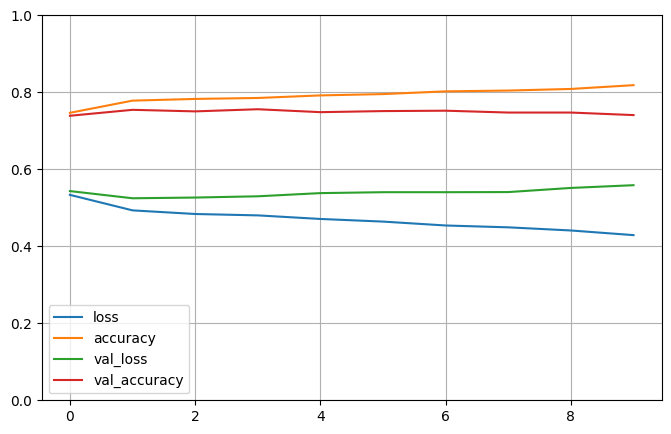

accuracy: 74.08%
Fold 1
Train set ones/size 7182 / 16055
Valid set ones/size 1697 / 3789
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
502/502 [==============================] - 2s 3ms/step - loss: 0.5291 - accuracy: 0.7587 - val_loss: 0.5027 - val_accuracy: 0.7691
Epoch 2/10
502/502 [==============================] - 1s 3ms/step - loss: 0.5000 - accuracy: 0.7779 - val_loss: 0.4977 - val_accuracy: 0.7722
Epoch 3/10
502/502 [==============================] - 1s 3ms/step - loss: 0.4886 - accuracy: 0.7822 - val_loss: 0.5067 - val_accuracy: 0.7696
Epoch 4/10
502/502 [==============================] - 1s 3ms/step - loss: 0.4819 - accuracy: 0.7878 - val_loss: 0.5047 - val_accuracy: 0.7664
Epoch 5/10
502/502 [==============================] - 1s 3ms/step - loss: 0.4731 - accuracy: 0.7927 - val_loss: 0.5063 - val_accuracy: 0.7604
Epoch 6/10
502/502 [==============================] - 1s 3ms/step - loss: 0.4627 - accuracy: 0.8004 - val_loss: 0.5212 - val_accuracy: 0.7643
Epoch 7/10
502/502 [

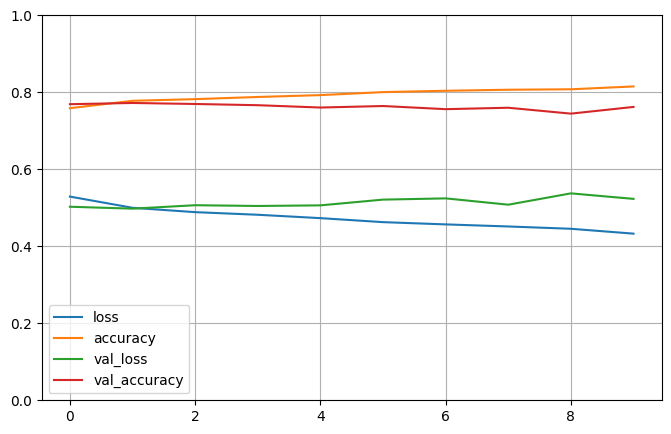

accuracy: 76.19%
Fold 2
Train set ones/size 7070 / 15718
Valid set ones/size 1809 / 4126
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
492/492 [==============================] - 2s 3ms/step - loss: 0.5281 - accuracy: 0.7514 - val_loss: 0.5441 - val_accuracy: 0.7472
Epoch 2/10
492/492 [==============================] - 1s 3ms/step - loss: 0.4927 - accuracy: 0.7796 - val_loss: 0.5509 - val_accuracy: 0.7312
Epoch 3/10
492/492 [==============================] - 1s 3ms/step - loss: 0.4816 - accuracy: 0.7852 - val_loss: 0.5474 - val_accuracy: 0.7295
Epoch 4/10
492/492 [==============================] - 1s 3ms/step - loss: 0.4724 - accuracy: 0.7934 - val_loss: 0.5502 - val_accuracy: 0.7450
Epoch 5/10
492/492 [==============================] - 1s 3ms/step - loss: 0.4646 - accuracy: 0.7962 - val_loss: 0.5527 - val_accuracy: 0.7365
Epoch 6/10
492/492 [==============================] - 1s 3ms/step - loss: 0.4569 - accuracy: 0.7986 - val_loss: 0.5479 - val_accuracy: 0.7426
Epoch 7/10
492/492 [

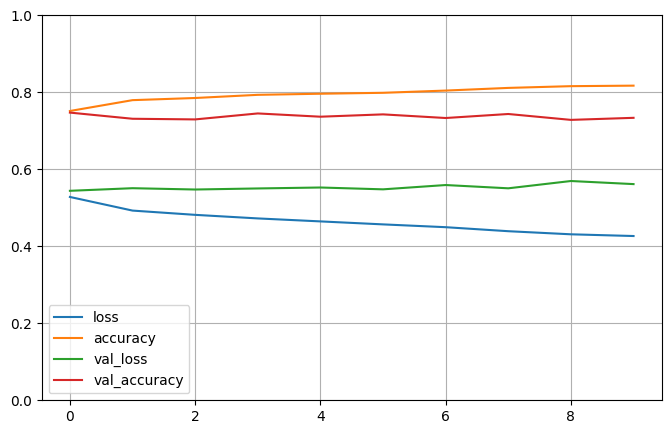

accuracy: 73.36%
Fold 3
Train set ones/size 6994 / 15727
Valid set ones/size 1885 / 4117
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
492/492 [==============================] - 2s 3ms/step - loss: 0.5539 - accuracy: 0.7321 - val_loss: 0.4990 - val_accuracy: 0.7666
Epoch 2/10
492/492 [==============================] - 1s 2ms/step - loss: 0.5089 - accuracy: 0.7683 - val_loss: 0.4961 - val_accuracy: 0.7848
Epoch 3/10
492/492 [==============================] - 1s 2ms/step - loss: 0.4923 - accuracy: 0.7797 - val_loss: 0.4991 - val_accuracy: 0.7695
Epoch 4/10
492/492 [==============================] - 1s 3ms/step - loss: 0.4825 - accuracy: 0.7858 - val_loss: 0.4913 - val_accuracy: 0.7797
Epoch 5/10
492/492 [==============================] - 1s 3ms/step - loss: 0.4718 - accuracy: 0.7914 - val_loss: 0.5001 - val_accuracy: 0.7739
Epoch 6/10
492/492 [==============================] - 1s 3ms/step - loss: 0.4632 - accuracy: 0.7945 - val_loss: 0.5055 - val_accuracy: 0.7685
Epoch 7/10
492/492 [

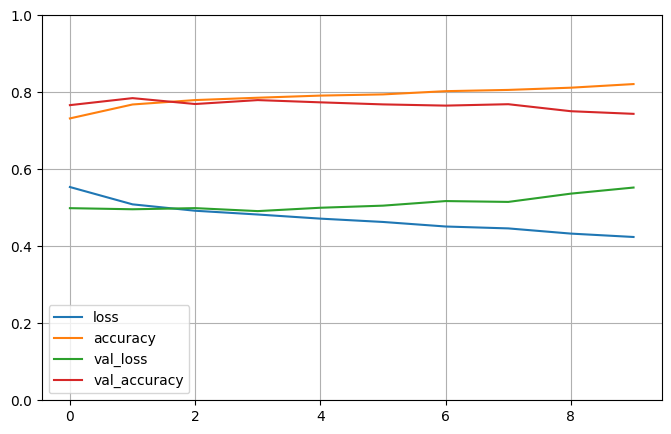

accuracy: 74.40%
Fold 4
Train set ones/size 7165 / 15982
Valid set ones/size 1714 / 3862
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
500/500 [==============================] - 2s 3ms/step - loss: 0.5320 - accuracy: 0.7420 - val_loss: 0.5021 - val_accuracy: 0.7861
Epoch 2/10
500/500 [==============================] - 1s 3ms/step - loss: 0.4953 - accuracy: 0.7722 - val_loss: 0.5101 - val_accuracy: 0.7734
Epoch 3/10
500/500 [==============================] - 1s 2ms/step - loss: 0.4861 - accuracy: 0.7798 - val_loss: 0.5105 - val_accuracy: 0.7768
Epoch 4/10
500/500 [==============================] - 1s 2ms/step - loss: 0.4772 - accuracy: 0.7853 - val_loss: 0.5169 - val_accuracy: 0.7708
Epoch 5/10
500/500 [==============================] - 1s 3ms/step - loss: 0.4659 - accuracy: 0.7948 - val_loss: 0.5136 - val_accuracy: 0.7698
Epoch 6/10
500/500 [==============================] - 1s 2ms/step - loss: 0.4568 - accuracy: 0.8008 - val_loss: 0.5122 - val_accuracy: 0.7737
Epoch 7/10
500/500 [

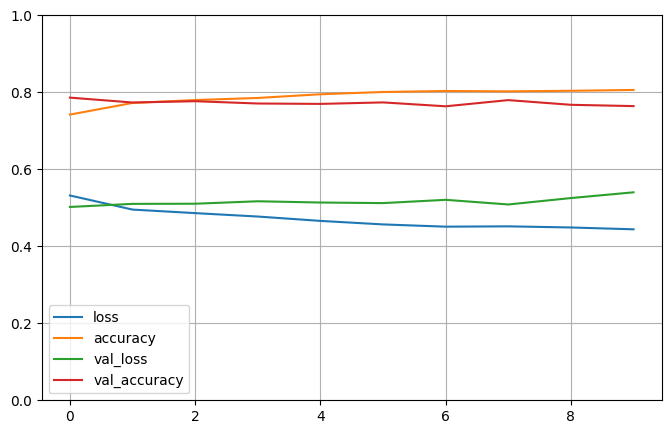

accuracy: 76.41%

Validation core mean 74.89% (+/- 1.20%)
2022-10-11 13:10:30.954291


In [13]:
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

print ("Cross valiation")
do_cross_validation(splitter,EPOCHS)
print(datetime.now())

# to do
Do train/valid split with respect to genes. 